In [1]:
import numpy as np
import astropy.units as u
import astropy.io.fits as fits

import matplotlib.pyplot as plt

import copy

from scoobpsf.math_module import xp, ensure_np_array
from scoobpsf.utils import pad_or_crop
from scoobpsf.imshows import *

import lina

from importlib import reload

pupil_diam = 6.75*u.mm
wavelength = 633*u.nm
fl = 127*u.mm

as_per_lamD = ((wavelength/pupil_diam)*u.radian).to(u.arcsec)
um_per_lamD = (fl*wavelength/pupil_diam).to(u.um)

def kneePSD(f,beta,fn,alpha):
    psd = beta/(1+f/fn)**alpha
    try:
        psd.decompose()
        return psd
    except:
        return psd
    
def generate_time_series(psd):
    P_fft_one_sided = copy.copy(psd)

    N_P = len(P_fft_one_sided)  # Length of PSD
    N = 2*(N_P - 1)
    print(N_P, N)

    # Because P includes both DC and Nyquist (N/2+1), P_fft must have 2*(N_P-1) elements
    P_fft_one_sided[0] = P_fft_one_sided[0] * 2
    P_fft_one_sided[-1] = P_fft_one_sided[-1] * 2
    P_fft_new = np.zeros((N,), dtype=complex)
    P_fft_new[0:int(N/2)+1] = P_fft_one_sided
    P_fft_new[int(N/2)+1:] = P_fft_one_sided[-2:0:-1]

    X_new = np.sqrt(P_fft_new)

    # Create random phases for all FFT terms other than DC and Nyquist
    phases = np.random.uniform(0, 2*np.pi, (int(N/2),))

    # Ensure X_new has complex conjugate symmetry
    X_new[1:int(N/2)+1] = X_new[1:int(N/2)+1] * np.exp(2j*phases)
    X_new[int(N/2):] = X_new[int(N/2):] * np.exp(-2j*phases[::-1])
    X_new = X_new * np.sqrt(N) / np.sqrt(2)

    # This is the new time series with a given PSD
    x_new = scipy.fft.ifft(X_new)

    print(np.sqrt(np.sum(np.square(x_new.real))), np.sqrt(np.sum(np.square(x_new.imag))))

    return x_new.real


    

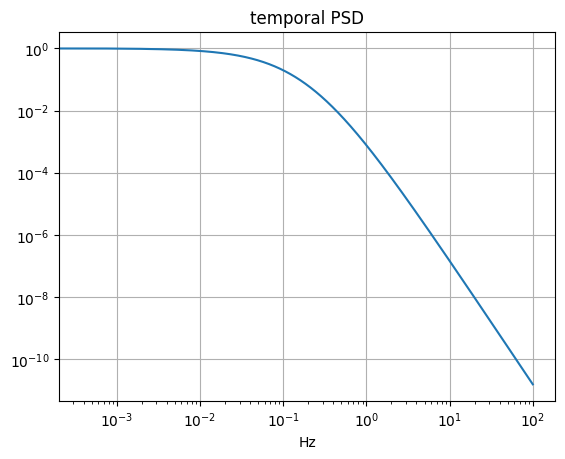

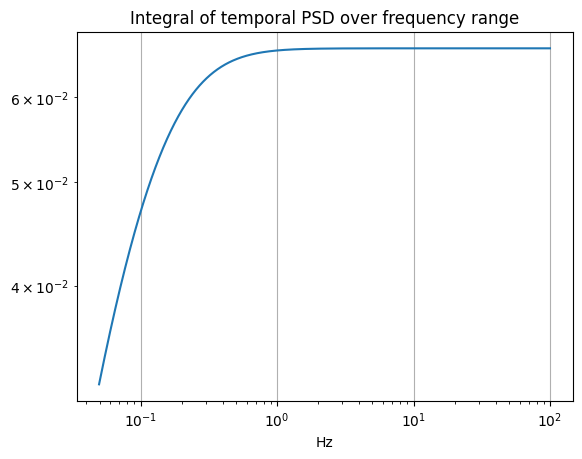

In [2]:
Nf = 2**18 + 1
f_min = 0*u.Hz
f_max = 100*u.Hz
del_f = (f_max - f_min)/Nf
freqs = np.arange(f_min.value, f_max.value, del_f.value) * u.Hz

Nt = 2*(Nf-1)
del_t = (1/(2*f_max)).to(u.s)
times = np.linspace(0, (Nt-1)*del_t, Nt)

f_knee = 0.2*u.Hz
psd = kneePSD(freqs, 1, f_knee, 4) #(freq,beta,fn,alpha)

Nints = 2000
int_freqs = []
psd_int = []
for i in range(Nints):
    i_psd = int(np.round(Nf/(Nints-i)))
    int_freqs.append(freqs[i_psd-1].to_value(u.Hz))
    psd_int.append(np.trapz(psd[:i_psd])*del_f.value)

plt.plot(freqs,psd)
plt.title(f"temporal PSD")
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.xlabel(freqs.unit)
plt.show()

plt.plot(int_freqs, psd_int)
plt.title(f"Integral of temporal PSD over frequency range")
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.xlabel(freqs.unit)
plt.show()

262145 524288
13.238729837974248 2.4583833233906844e-15
262145 524288
13.238729837974253 2.480669960482379e-15


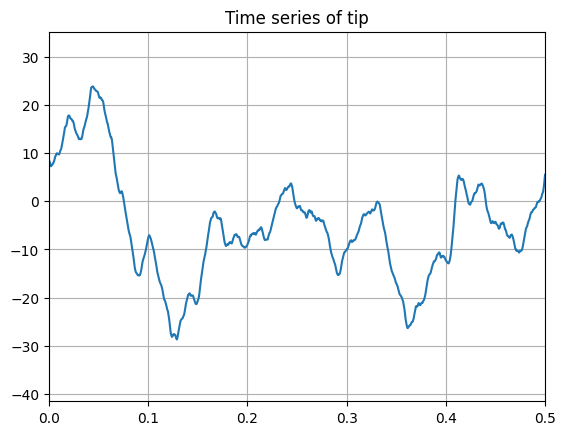

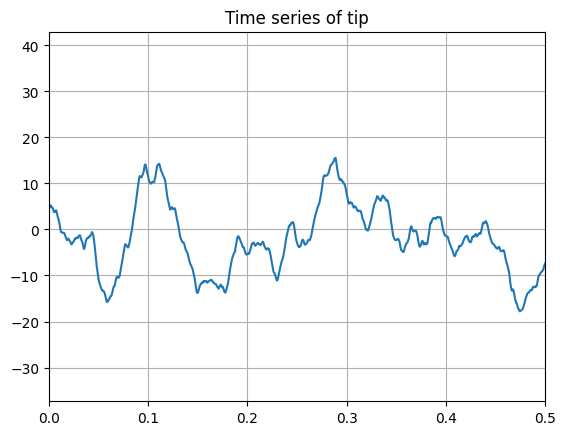

In [3]:
rms = 10*u.arcsec

tip = generate_time_series(psd)
tip *= rms.to_value(u.arcsec)/np.sqrt(np.mean(np.square(tip)))

tilt = generate_time_series(psd)
tilt *= rms.to_value(u.arcsec)/np.sqrt(np.mean(np.square(tilt)))

plt.plot(times/60, tip)
plt.title('Time series of tip')
plt.grid()
plt.xlim([0,0.5])
plt.show()

plt.plot(times/60, tilt)
plt.title('Time series of tip')
plt.grid()
plt.xlim([0,0.5])
plt.show()

In [9]:
pointing_error_series = np.concatenate([[times],[tip],[tilt]])
pointing_error_series.shape

(3, 524288)

In [8]:
times.shape

(524288,)

In [10]:
utils.save_fits('pointing_error_time_series.fits', pointing_error_series)

Saved data to:  pointing_error_time_series.fits
